In [1]:
# import relevant packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_crime_data
from datetime import datetime
import prepare
import seaborn as sns
from wrangle import *
from explore import *
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_seq_items', None)
pd.set_option('expand_frame_repr', True)
pd.set_option('display.large_repr', 'truncate')
np.set_printoptions(linewidth=160)

In [2]:
# plotting defaults
plt.rc('figure', figsize=(23, 10))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [3]:
df = get_crime_data(use_cache = False)

Acquiring data from api


In [4]:
df = wrangle_merged_df()

Using cached csv


In [5]:
df.crime_type.count()

352986

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352986 entries, 0 to 352985
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   crime_type            352986 non-null  object         
 1   family_violence       352986 non-null  object         
 2   occurrence_time       352986 non-null  datetime64[ns] 
 3   occurrence_date       352986 non-null  datetime64[ns] 
 4   report_time           352986 non-null  datetime64[ns] 
 5   report_date           352986 non-null  datetime64[ns] 
 6   location_type         352986 non-null  object         
 7   address               352986 non-null  object         
 8   zip_code              352986 non-null  float64        
 9   council_district      352986 non-null  float64        
 10  sector                352986 non-null  object         
 11  district              352986 non-null  object         
 12  latitude              352986 non-null  float

In [7]:
#Assign my .shp file to a variable named “asutin_map”
#austin_map = gpd.read_file('Boundaries_zipcode/geo_export_9b5aa23d-57b1-41f4-b4f9-0a9d97fac540.shp')

In [8]:
#austin_map = austin_map.drop(columns =['affgeoid10','geoid10','aland10','awater10'])

In [9]:
#austin_map = austin_map.rename(columns ={'zcta5ce10': 'zip_code'})

In [10]:
#austin_map = austin_map.astype({"zip_code": float}, errors='raise') 

In [11]:
#create a new dataframe with both our geographical and statistical data in it by merging our two tables together.
#new_df = austin_map.merge(df, on ='zip_code')

In [12]:
#new_df.to_csv('Geo_Crime_Reports.csv')

In [13]:
#new_df.info()

In [14]:
#new_df.head()

In [15]:
#Crime_type by zip_code
#fig, ax = plt.subplots(1, figsize=(8, 8))
#plt.xticks(rotation=90)
#new_df.plot(column="crime_type", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
#bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=120))
#bar_info._A = []
#cbar = fig.colorbar(bar_info)

# We predict that there is a relationship between higher seasonal levels of crime and clearance status.

In [16]:
train, validate, test = prepare.split_data(df)

In [17]:
train.shape

(197671, 40)

In [18]:
train2 = train.copy()

In [19]:
#df['occurrence_date']= pd.to_datetime(df['occurrence_date'])
train2 = train2.set_index('occurrence_time').sort_index()

In [53]:
#Split by month first
train2['month'] = train2.index.month_name()
train2['weekdays'] = train2.index.day_name()
train2['year'] = train2.index.year
train2['month_num']=train2.index.month

In [21]:
#train2.groupby(train2.occurrence_date.dt.month).crime_type.count().idxmax()

In [22]:
y = train2.groupby(['weekdays','year'])['crime_type'].count()

In [23]:
y

weekdays   year
Friday     2018    7662
           2019    8269
           2020    7510
           2021    6847
Monday     2018    7351
           2019    7526
           2020    7211
           2021    6417
Saturday   2018    7525
           2019    7586
           2020    7036
           2021    6191
Sunday     2018    7009
           2019    7538
           2020    6963
           2021    6226
Thursday   2018    7118
           2019    7077
           2020    7116
           2021    6162
Tuesday    2018    6835
           2019    7430
           2020    7173
           2021    5946
Wednesday  2018    7093
           2019    7260
           2020    7444
           2021    6150
Name: crime_type, dtype: int64

In [24]:
y_max = train2.groupby(['weekdays','year'])['crime_type'].count().max()

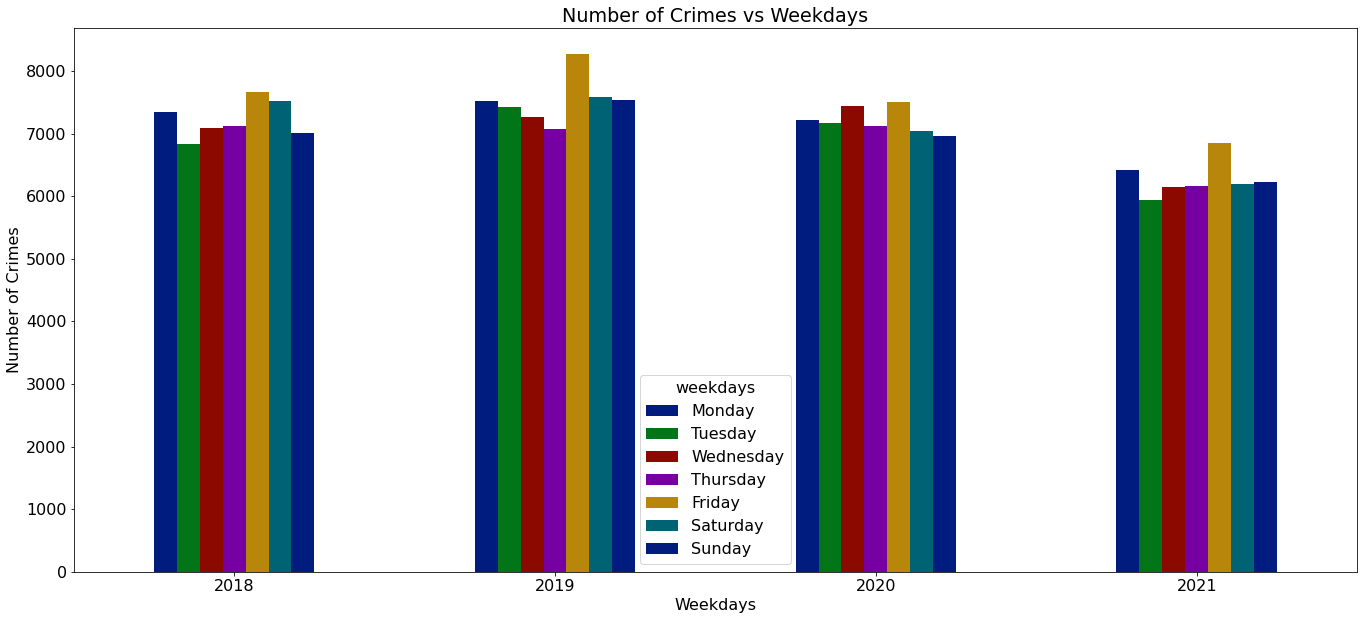

In [25]:
#Take a look at all the crime types
train2['weekdays'] = pd.Categorical(train2['weekdays'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#overall_mean = df.groupby('month').crime_type.value_counts()
#Assuming 0 = Sunday, 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 =Saturday
train2.groupby(['weekdays','year'])['crime_type'].count().unstack(0).plot.bar()
#sns.barplot(x=None, y = y, data = y, ci = None)
plt.title("Number of Crimes vs Weekdays")
plt.xlabel("Weekdays")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

In [26]:
friday_only = ['Friday']

In [27]:
subset_friday = train2.copy()

In [28]:
subset_friday = subset_friday[subset_friday.weekdays.isin(friday_only)]#With just friday only

In [29]:
subset_not_friday = train2.copy()

In [30]:
subset_not_friday = subset_not_friday[~subset_not_friday.weekdays.isin(friday_only)]#Without friday

### Stats Test

We'll be testing the following hypothesis:

$H_0$: There is no difference in crime levels between Fridays and other days of the week.
<br>
$H_a$: There is difference in crime levels between Fridays and other days of the week.

In [31]:
#Do 1 sample t-test compare friday vs the rest
#Need to subset the data just friday only and other exclude the friday and do 1 sample ttest
t_test_ind(subset_not_friday.cleared, subset_friday.cleared)

The t value between the two samples is 0.5134 and the P-Value is 0.6076501474487024.
----------------------------------------------------------------------------
Since the P value is greater than the alpha, we fail to reject the null hypothesis.


In [54]:
train2.tail()

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,pd_district,the_geom,objectid,district_name,sort_order,battalion_id,jurisdiction_id,color,code,external_key,battalion_code,sector_name,input_date,modified_date,input_by,modified_by,bureau_name,patrol_area,command_phone_number,primary_key,shape_area,shape_length,month,weekdays,year,report_hour,report_hour_bins,month_num
occurrence_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00,BURGLARY OF VEH-NO SUSPECT/FU,N,2021-12-31,2022-01-06 13:04:00,2022-01-06,RESIDENCE / HOME,10414 BROKEN SHOE TRL,78750.0,6.0,ADAM,6,30.453633,-97.802507,not cleared,2022-01-13,False,5 days 14:04:00,ADAM 6,MULTIPOLYGON (((-97.766457391718 30.4326842359...,67,ADAM 6,1,21,6,16744448,1272,1272,A1,ADAM,12/22/2014 11:31:16 AM +0000,09/02/2020 03:09:12 PM +0000,bmartinlimuel,ap7657,NORTH,NORTHWEST,512-974-5500,77,8.651601e+07,59271.466409,December,Friday,2021,23,Night,12
2021-12-31 23:00:00,BURGLARY OF RESIDENCE,N,2021-12-31,2022-01-13 09:44:00,2022-01-13,RESIDENCE / HOME,2501 PARKER LN,78741.0,3.0,HENRY,2,30.229872,-97.738235,not cleared,2022-03-15,False,12 days 10:44:00,HENRY 2,MULTIPOLYGON (((-97.728280447687 30.2474658449...,63,HENRY 2,1,205,59,16711808,1300,1300,H1,HENRY,12/22/2014 11:31:16 AM +0000,09/06/2018 08:51:39 AM +0000,bmartinlimuel,AP7657,SOUTH,SOUTHCENTRAL,512-974-8106,7,5.956868e+07,45776.057157,December,Friday,2021,23,Night,12
2021-12-31 23:30:00,DISTURBANCE - OTHER,N,2021-12-31,2021-12-31 23:30:00,2021-12-31,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,11308 WALNUT RIDGE DR,78753.0,1.0,EDWARD,7,30.375075,-97.669611,not cleared,2022-01-03,False,0 days 00:00:00,EDWARD 7,MULTIPOLYGON (((-97.652442658383 30.3876563065...,87,EDWARD 7,1,174,13,16711680,1291,1291,E1,EDWARD,12/22/2014 11:31:16 AM +0000,10/09/2018 01:44:41 PM +0000,bmartinlimuel,APD_ADMIN,CENTRAL,NORTHEAST,512-974-5500,91,7.910069e+07,46998.269790,December,Friday,2021,23,Night,12
2021-12-31 23:40:00,AGG ASLT STRANGLE/SUFFOCATE,Y,2021-12-31,2022-01-01 00:44:00,2022-01-01,RESIDENCE / HOME,10000 N LAMAR BLVD,78758.0,4.0,EDWARD,1,30.369262,-97.695105,not cleared,2022-01-05,False,0 days 01:04:00,EDWARD 1,MULTIPOLYGON (((-97.694118479216 30.3826672092...,57,EDWARD 1,1,174,13,16711680,1288,1288,E1,EDWARD,12/22/2014 11:31:16 AM +0000,10/09/2018 01:43:05 PM +0000,bmartinlimuel,APD_ADMIN,CENTRAL,NORTHEAST,512-974-5500,72,8.356489e+07,46296.345268,December,Friday,2021,23,Night,12
2021-12-31 23:50:00,THEFT,N,2021-12-31,2022-01-07 14:12:00,2022-01-07,OTHER / UNKNOWN,6936 E BEN WHITE BLVD SVRD WB,78741.0,3.0,HENRY,5,30.215264,-97.703019,not cleared,2022-01-10,False,6 days 14:22:00,HENRY 5,MULTIPOLYGON (((-97.68027216016 30.24573035933...,75,HENRY 5,1,205,59,16711808,1302,1302,H1,HENRY,12/22/2014 11:31:16 AM +0000,10/09/2018 01:43:44 PM +0000,bmartinlimuel,APD_ADMIN,SOUTH,SOUTHCENTRAL,512-974-8106,79,7.419049e+07,44745.588196,December,Friday,2021,23,Night,12


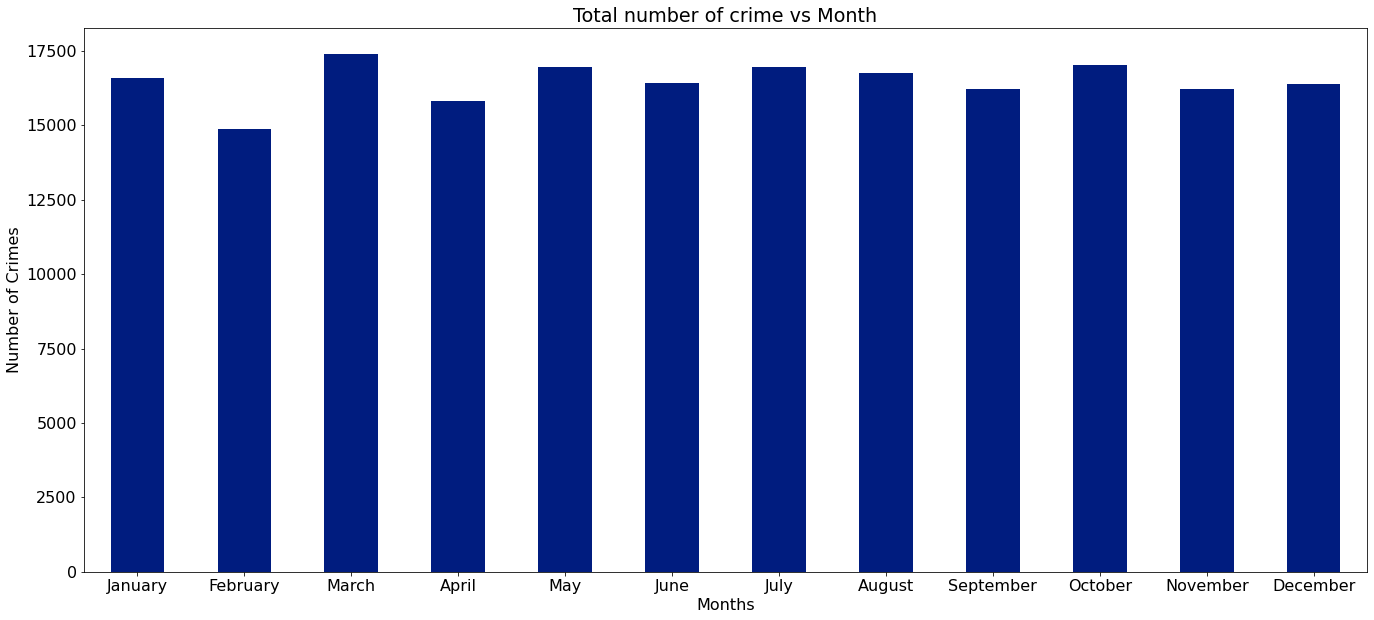

In [33]:
#Take a look at all the crime types
train2['month'] = pd.Categorical(train2['month'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                                                            'September','October', 'November', 'December'])
#overall_mean = df.groupby('month').crime_type.value_counts()
train2.groupby('month').crime_type.count().plot.bar()
plt.title("Total number of crime vs Month")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

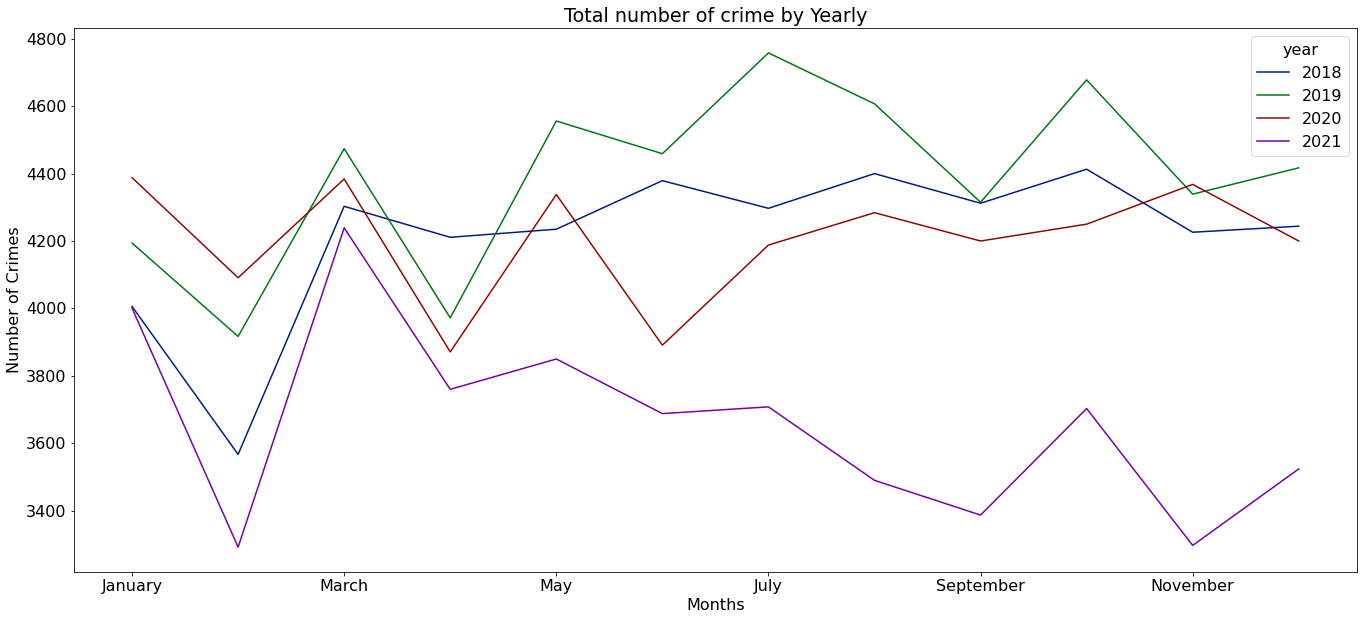

In [34]:
train2.groupby(['year', 'month']).cleared.count().unstack(0).plot.line()
plt.title("Total number of crime by Yearly")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.tick_params('x', rotation=360)
#plt.axhline(overall_mean,color="r")
None

#### Take away 
- From the visuals, we can see that Friday (2019) has higest, all the months have almost the same number of crime and year of 2019. But still need to take a look deeper into which weekday of the year has the higest number.

In [35]:
train2 ['report_hour'] = train2.index.hour

In [36]:
train2 = train2.astype({'report_hour':int}, errors='raise')

In [57]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 197671 entries, 2018-01-01 00:00:00 to 2021-12-31 23:50:00
Data columns (total 45 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   crime_type            197671 non-null  object         
 1   family_violence       197671 non-null  object         
 2   occurrence_date       197671 non-null  datetime64[ns] 
 3   report_time           197671 non-null  datetime64[ns] 
 4   report_date           197671 non-null  datetime64[ns] 
 5   location_type         197671 non-null  object         
 6   address               197671 non-null  object         
 7   zip_code              197671 non-null  float64        
 8   council_district      197671 non-null  float64        
 9   sector                197671 non-null  object         
 10  district              197671 non-null  object         
 11  latitude              197671 non-null  float64        
 12  longitude 

In [63]:
#What type of lockdown in austin?
train2.groupby(['patrol_area','season','occurrence_date','year','crime_type']).clearance_status.count().sort_values(ascending=False).head(35)

patrol_area   season  occurrence_date  year  crime_type         
SOUTHWEST     Fall    2019-10-06       2019  THEFT FROM PERSON      29
                      2019-10-05       2019  THEFT FROM PERSON      28
                      2019-10-04       2019  THEFT FROM PERSON      24
                      2021-10-02       2021  THEFT FROM PERSON      21
                      2019-10-04       2019  THEFT                  20
                      2019-10-05       2019  THEFT                  19
                      2018-10-13       2018  THEFT FROM PERSON      18
                      2021-10-09       2021  THEFT FROM PERSON      18
                      2019-10-06       2019  THEFT                  16
NORTHWEST     Winter  2019-11-06       2019  BURGLARY OF VEHICLE    16
SOUTHWEST     Fall    2021-10-03       2021  THEFT FROM PERSON      15
                      2018-10-06       2018  THEFT FROM PERSON      14
                      2018-10-14       2018  THEFT FROM PERSON      14
NORTHWEST   

In [39]:
train2.report_hour.min

<bound method NDFrame._add_numeric_operations.<locals>.min of occurrence_time
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
2018-01-01 00:00:00     0
                       ..
2021-12-31 23:00:00    23
2021-12-31 23:00:00    23
2021-12-31 23:30:00    23
2021-12-31 23:40:00    23
2021-12-31 23:50:00    23
Name: report_hour, Length: 197671, dtype: int64>

In [40]:
def f(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [55]:
def map_month(x):
    if (x > 1) and (x <= 3):
        return 'Spring'
    elif (x > 3) and (x <=7):
        return 'Summer'
    elif (x > 7) and (x <=10):
        return 'Fall'
    elif (x > 10) and (x <=12):
        return 'Winter'

In [58]:
train2['season'] = train2['month_num'].apply(map_month)

In [41]:
train2['report_hour_bins'] = train2['report_hour'].apply(f)

In [42]:
#train2 ['report_hour_bins'] = pd.cut(train2['report_hour'], bins = bins, labels = labels, right = False)
                                                    

In [59]:
train2.sample(10)

,crime_type,family_violence,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,pd_district,the_geom,objectid,district_name,sort_order,battalion_id,jurisdiction_id,color,code,external_key,battalion_code,sector_name,input_date,modified_date,input_by,modified_by,bureau_name,patrol_area,command_phone_number,primary_key,shape_area,shape_length,month,weekdays,year,report_hour,report_hour_bins,month_num,season
occurrence_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-29 17:00:00,FAMILY DISTURBANCE,N,2020-05-29,2020-05-29 17:00:00,2020-05-29,RESIDENCE / HOME,5303 INDIO CIR,78745.0,5.0,DAVID,4,30.222613,-97.804196,not cleared,2020-07-05,False,0 days 00:00:00,DAVID 4,MULTIPOLYGON (((-97.783022731369 30.2445288343...,81,DAVID 4,1,164,12,16711680,1286,1286,D1,DAVID,12/22/2014 11:31:16 AM +0000,10/09/2018 01:44:27 PM +0000,bmartinlimuel,APD_ADMIN,SOUTH,SOUTHWEST,512-974-8100,87,1.491496e+08,104111.511168,May,Friday,2020,17,Evening,5,Summer
2021-08-04 10:37:00,CRIMINAL TRESPASS,N,2021-08-04,2021-08-04 10:40:00,2021-08-04,RESIDENCE / HOME,1300 E RIVERSIDE DR,78741.0,9.0,HENRY,2,30.248501,-97.733939,not cleared,2021-08-05,False,0 days 00:03:00,HENRY 2,MULTIPOLYGON (((-97.728280447687 30.2474658449...,63,HENRY 2,1,205,59,16711808,1300,1300,H1,HENRY,12/22/2014 11:31:16 AM +0000,09/06/2018 08:51:39 AM +0000,bmartinlimuel,AP7657,SOUTH,SOUTHCENTRAL,512-974-8106,7,5.956868e+07,45776.057157,August,Wednesday,2021,10,Morning,8,Fall
2019-10-01 01:00:00,TERRORISTIC THREAT-FAM/DAT VIO,Y,2019-10-01,2019-10-03 15:43:00,2019-10-03,RESIDENCE / HOME,4802 YORK HILL DR,78723.0,1.0,CHARLIE,4,30.287979,-97.672274,cleared by arrest,2019-10-10,True,2 days 14:43:00,CHARLIE 4,MULTIPOLYGON (((-97.669979365055 30.3064058684...,28,CHARLIE 4,1,400,11,16744576,1280,1280,CHAR,CHARLIE,12/22/2014 11:31:16 AM +0000,10/09/2018 01:42:05 PM +0000,bmartinlimuel,APD_ADMIN,CENTRAL,CENTRALEAST,512-974-5900,62,8.636998e+07,54230.376197,October,Tuesday,2019,1,Late Night,10,Fall
2020-07-15 12:00:00,CHILD CUSTODY INTERFERE,N,2020-07-15,2020-07-17 10:30:00,2020-07-17,OTHER / UNKNOWN,8102 WASHITA DR,78749.0,8.0,DAVID,7,30.206673,-97.846496,not cleared,2020-07-17,False,1 days 22:30:00,DAVID 7,MULTIPOLYGON (((-97.854395318936 30.2247304224...,84,DAVID 7,1,164,12,16711680,1286,1286,D1,DAVID,12/22/2014 11:31:16 AM +0000,10/09/2018 01:44:29 PM +0000,bmartinlimuel,APD_ADMIN,SOUTH,SOUTHWEST,512-974-8100,88,1.570599e+08,62761.932667,July,Wednesday,2020,12,Morning,7,Summer
2018-10-13 23:00:00,CRASH/FAIL STOP AND RENDER AID,N,2018-10-13,2018-10-15 12:38:00,2018-10-15,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,W SLAUGHTER LN / S 1ST ST,78748.0,5.0,FRANK,2,30.172450,-97.799555,not cleared,2018-10-31,False,1 days 13:38:00,FRANK 2,MULTIPOLYGON (((-97.786075968711 30.1670516679...,32,FRANK 2,1,184,14,16744448,1293,1293,F1,FRANK,12/22/2014 11:31:16 AM +0000,10/09/2018 01:42:25 PM +0000,bmartinlimuel,APD_ADMIN,SOUTH,SOUTHEAST,512-974-8200,66,9.809978e+07,52202.458378,October,Saturday,2018,23,Night,10,Fall
2020-02-15 00:18:00,VIOL OF PROTECTIVE ORDER,N,2020-02-15,2020-02-15 00:18:00,2020-02-15,RESIDENCE / HOME,1438 CORONADO HILLS DR,78752.0,1.0,IDA,2,30.328124,-97.688656,not cleared,2020-02-20,False,0 days 00:00:00,IDA 2,MULTIPOLYGON (((-97.680571226059 30.3352758192...,37,IDA 2,1,215,60,16711680,1304,1304,I1,IDA,12/22/2014 11:31:16 AM +0000,09/06/2018 08:54:11 AM +0000,bmartinlimuel,AP7657,CENTRAL,NORTHCENTRAL,512-974-5203,21,4.113775e+07,34696.294289,February,Saturday,2020,0,Late Night,2,Spring
2021-10-16 08:18:00,AGG ASSAULT,N,2021-10-16,2021-10-16 08:18:00,2021-10-16,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,MONTOPOLIS DR / BASTROP SB TO MONTOPOLIS RAMP,78741.0,3.0,HENRY,5,30.242158,-97.692109,cleared by arrest,2021-10-16,True,0 days 00:00:00,HENRY 5,MULTIPOLYGON (((-97.68027216016 30.24573035933...,75,HENRY 5,1,205,59,16711808,1302,1302,H1,HENRY,12/22/2014 11:31:16 AM +0000,1

In [44]:
train2.report_hour_bins.value_counts()

Evening          44826
Late Night       36492
Noon             35282
Morning          33917
Night            31505
Early Morning    15649
Name: report_hour_bins, dtype: int64

<AxesSubplot:ylabel='weekdays,clearance_status'>

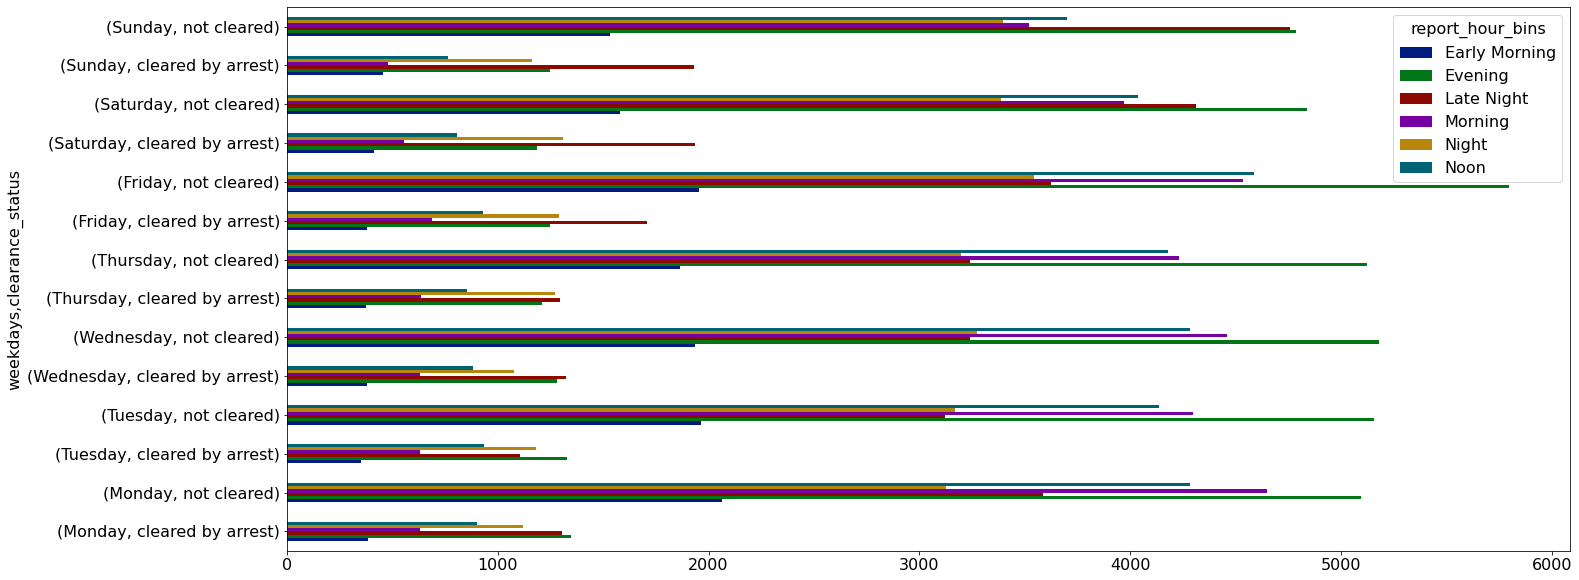

In [45]:
#Quick visual
train2.groupby(['report_hour_bins','weekdays','clearance_status']).crime_type.count().unstack(0).plot.barh()

In [46]:
#Note: During the evening time there is more crime compare to early morning. But which crime is more like to happen at that hour?

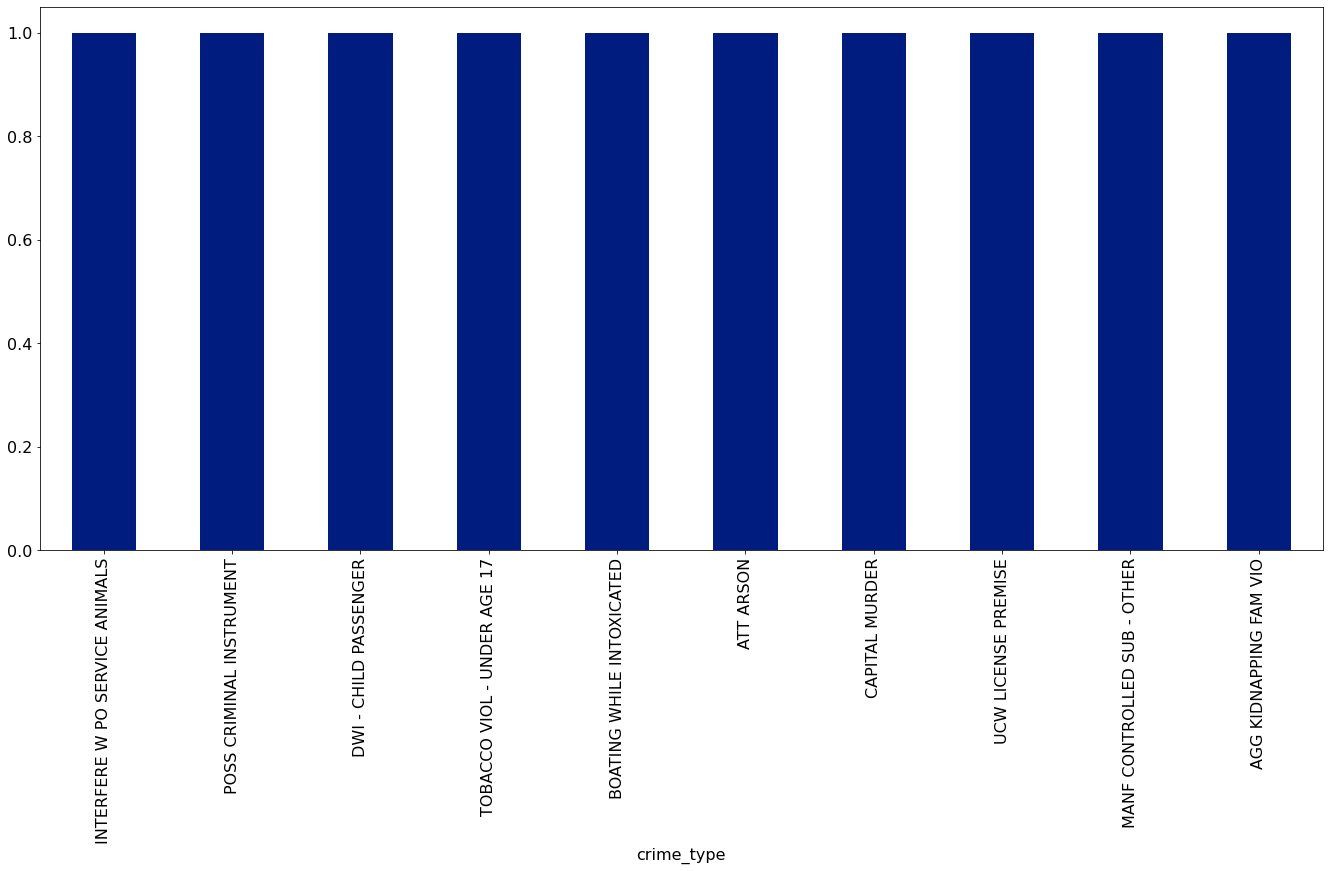

In [47]:
#Look at the top 10 crime types that get cleared
train2.groupby(['crime_type']).cleared.mean().sort_values(ascending = False).head(10).plot.bar();

In [48]:
train2.cleared.mean()

0.2070561690890419

<AxesSubplot:ylabel='year'>

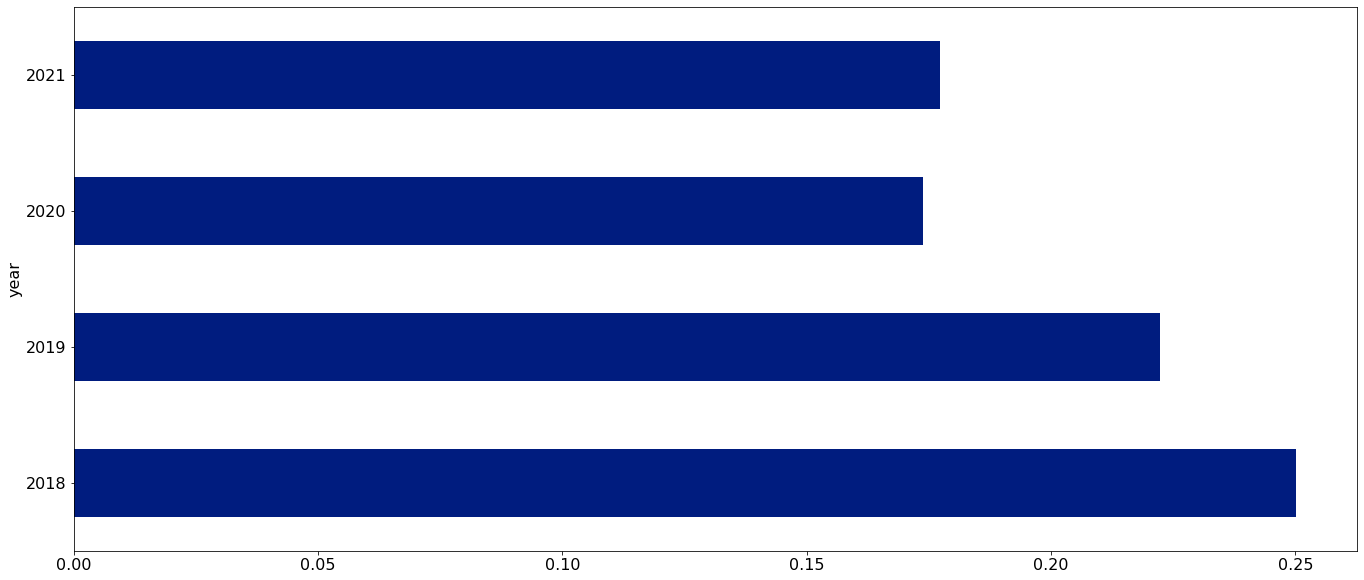

In [49]:
train2.groupby(['year']).cleared.mean().plot.barh()